# Visualizaciones con lenguaje natural utilizando LLMs + herramientas de langchain 

## PythonREPLTool

una herramienta que permite ejecutar código Python en un entorno de ejecución. Esta herramienta es útil para realizar cálculos, transformar datos y ejecutar scripts de Python directamente desde el agente.


In [ ]:
# pip install langchain langchain-experimental langchain-google-genai pandas

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_experimental.tools.python.tool import PythonREPLTool
import re
import pandas as pd

# Instanciar el modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.3,
    google_api_key="tu_api_key",
    verbose=True
)

# Instanciar el REPL
repl = PythonREPLTool()

# Prompt en lenguaje natural
prompt = """
Usá el DataFrame `df` ya cargado con datos de conectividad en el AMBA.
Contiene las columnas: 'id', 'distrito', 'provincia', 'total_hogares', 'tiene_internet', 'no_tiene_internet'.

Generá exclusivamente código Python entre ```python ... ```.
Calcular frecuencias relativas de hogares con y sin internet por provincia.

Mostrá los resultados en un DataFrame.
"""

# Invocar el modelo
response = llm.invoke(prompt)

# Extraer bloque de código generado por el modelo
match = re.search(r"```python(.*?)```", response.content, re.DOTALL)
code_block = match.group(1).strip() if match else None

if not code_block:
    print("❌ No se encontró código válido.")
else:
    print("\n--- Código generado por el modelo ---\n")
    print(code_block)

    # Inyectar contexto mínimo para ejecutar el código
    injection = (
        "import pandas as pd\n"
        "df = pd.read_csv('amba_internet.csv')\n"
    )
    full_code = injection + "\n" + code_block

    try:
        # Ejecutar código dentro del entorno del REPL
        result = repl.invoke(full_code)
        print("\n--- Resultado de la ejecución ---\n")
        print(result)
    except Exception as e:
        print("❌ Error al ejecutar el código generado:")
        print(e)


Python REPL can execute arbitrary code. Use with caution.



--- Código generado por el modelo ---

import pandas as pd

# Calcular el total de hogares por provincia
total_hogares_por_provincia = df.groupby('provincia')['total_hogares'].sum()

# Calcular el total de hogares con internet por provincia
hogares_con_internet_por_provincia = df.groupby('provincia')['tiene_internet'].sum()

# Calcular el total de hogares sin internet por provincia
hogares_sin_internet_por_provincia = df.groupby('provincia')['no_tiene_internet'].sum()

# Calcular las frecuencias relativas
frecuencia_internet = hogares_con_internet_por_provincia / total_hogares_por_provincia
frecuencia_sin_internet = hogares_sin_internet_por_provincia / total_hogares_por_provincia

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    'frecuencia_internet': frecuencia_internet,
    'frecuencia_sin_internet': frecuencia_sin_internet
})

# Imprimir el DataFrame resultante
print(resultados)

--- Resultado de la ejecución ---

                           frecuencia_interne

In [ ]:
#validamos el resultado
df = pd.read_csv("amba_internet.csv")
df_grouped = df.groupby("provincia")[["tiene_internet", "no_tiene_internet"]].sum()
df_grouped["total"] = df_grouped["tiene_internet"] + df_grouped["no_tiene_internet"]
df_grouped["Frecuencia_Con_Internet"] = df_grouped["tiene_internet"] / df_grouped["total"]
df_grouped["Frecuencia_Sin_Internet"] = df_grouped["no_tiene_internet"] / df_grouped["total"]
resultado = df_grouped[["Frecuencia_Con_Internet", "Frecuencia_Sin_Internet"]].round(4)

print(resultado)


                           Frecuencia_Con_Internet  Frecuencia_Sin_Internet
provincia                                                                  
ciudad autonoma                             0.9000                   0.1000
provincia de buenos aires                   0.8185                   0.1815


In [ ]:
# variamos el pedido

In [4]:
# Instanciar el REPL
repl = PythonREPLTool()

# nuego prompt
prompt = """
Usá el DataFrame `df` ya cargado, con columnas: 
'id', 'distrito', 'provincia', 'total_hogares', 'tiene_internet', 'no_tiene_internet'.

Escribí exclusivamente código Python entre ```python ... ``` que:
- Filtre solo las filas donde la provincia sea "provincia de buenos aires"
- Calcule la tasa de conectividad como (tiene_internet / total_hogares) por distrito
- Identifique el distrito con mayor y menor tasa
- Cree un nuevo DataFrame llamado `resultado` con columnas:
  ['distrito', 'tasa_conectividad']
- Contenga únicamente esos dos distritos
- Ordene `resultado` de mayor a menor tasa
- Mostrá el DataFrame usando `print(resultado)`

"""

# Invocar Gemini
response = llm.invoke(prompt)
match = re.search(r"```python(.*?)```", response.content, re.DOTALL)
code_block = match.group(1).strip() if match else None

# Preparar el código con contexto
injection = (
    "import pandas as pd\n"
    "df = pd.read_csv('amba_internet.csv')\n"
)
full_code = injection + "\n" + code_block if code_block else None

# Ejecutar el código si fue extraído correctamente
execution_result = repl.invoke(full_code) if full_code else "❌ No se encontró código válido."
execution_result


'             distrito  tasa_conectividad\n52      Vicente López           0.914731\n28  General Rodríguez           0.660468\n'

In [ ]:
import pandas as pd

df = pd.read_csv("amba_internet.csv")
df["tasa_conectividad"] = df["tiene_internet"] / df["total_hogares"]
df_pba = df[df["provincia"] == "provincia de buenos aires"]
res = df_pba.loc[[df_pba["tasa_conectividad"].idxmax(), df_pba["tasa_conectividad"].idxmin()], ["distrito", "tasa_conectividad"]]
print(res.sort_values("tasa_conectividad", ascending=False))



             distrito  tasa_conectividad
52      Vicente López           0.914731
28  General Rodríguez           0.660468


## SampleCoT como herramienta funcional
Una herramienta que permite realizar razonamiento encadenado (Chain of Thought) utilizando un modelo de lenguaje. Esta herramienta es útil para descomponer problemas complejos en pasos más simples y resolverlos de manera secuencial. Utiliza la biblioteca `langchain` para implementar el razonamiento encadenado y generar respuestas más precisas y detalladas.

In [ ]:
from langchain_experimental.tot.thought_generation import SampleCoTStrategy
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
import re
from IPython.display import display, Markdown

# 1. Cargar el DataFrame
df = pd.read_csv("amba_internet.csv")

# 2. Instanciar modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.9,
    google_api_key="tu_api_key",
    verbose=True
)

# Instanciar SampleCoTStrategy
cot = SampleCoTStrategy(llm=llm, c=8, verbose=True)

# Definir el prompt
prompt = (
    "Usá el DataFrame `df` ya cargado.\n"
    "Contiene los campos: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.\n"
    "Calculá la tasa de conectividad como 'tiene_internet / total_hogares * 100' y llamala 'tasa_conectividad'.\n"
    "Debes devolver los *4 distritos* con menor tasa de conectividad.\n"
    "Retorná solo las columnas: 'distrito' y 'tasa_conectividad', ordenadas de menor a mayor.\n"
    "Usá `to_string(index=False)` para que la salida sea texto plano y guardala en una variable llamada `salida`.\n"
    "Devolvé únicamente código Python entre triple backticks, sin explicaciones."
)

# Generar pensamiento
thought = cot.next_thought(problem_description=prompt)
print("\n--- Pensamiento generado ---\n")
print(thought)

# Extraer y ejecutar código
match = re.search(r"```python(.*?)```", thought, re.DOTALL)
if match:
    code = match.group(1).strip()
    if not code.endswith("salida"):
        code += "\nsalida"

    exec_globals = {"df": df.copy()}
    exec(code, exec_globals)
    print("\n--- Resultado ---\n")
    print(exec_globals.get("salida", "[sin salida]"))
else:
    print("❌ No se encontró código válido.")



c:\Users\Pedro\Desktop\proyectos_25\agentes\.venv\Lib\site-packages\langchain\chains\llm.py:341: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(




> Entering new SampleCoTStrategy chain...
Prompt after formatting:
You are an intelligent agent that is generating one thought at a time in
a tree of thoughts setting.

PROBLEM 

Usá el DataFrame `df` ya cargado.
Contiene los campos: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.
Calculá la tasa de conectividad como 'tiene_internet / total_hogares * 100' y llamala 'tasa_conectividad'.
Debes devolver los *4 distritos* con menor tasa de conectividad.
Retorná solo las columnas: 'distrito' y 'tasa_conectividad', ordenadas de menor a mayor.
Usá `to_string(index=False)` para que la salida sea texto plano y guardala en una variable llamada `salida`.
Devolvé únicamente código Python entre triple backticks, sin explicaciones.



Let's think step by step.

> Finished chain.

--- Pensamiento generado ---

First. calculate the 'tasa_conectividad' column.
Second, select the 'distrito' and 'tasa_conectividad' columns.
Third, sort by 'tasa_conectividad' in ascending order.
Fourth, sele

In [ ]:
import pandas as pd  # Importamos la librería pandas

# Cargamos el dataset desde el archivo CSV
df = pd.read_csv("amba_internet.csv")

# Calculamos la tasa de conectividad como porcentaje y la guardamos en una nueva columna
df["tasa_conectividad"] = df["tiene_internet"] / df["total_hogares"] * 100

# Seleccionamos solo las columnas relevantes y ordenamos de menor a mayor tasa
resultado = df.loc[:, ["distrito", "tasa_conectividad"]].sort_values("tasa_conectividad").head(4)

# Mostramos el resultado final
print(resultado)

                 distrito  tasa_conectividad
28      General Rodríguez          66.046775
4                Brandsen          67.564721
49            San Vicente          71.503650
25  Exaltación de la Cruz          73.829401


## Implementación de una LLM para visualización de datos en lenguaje natural

c:\Users\Pedro\Desktop\proyectos_25\agentes\.venv\Lib\site-packages\langchain\chains\llm.py:341: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(




> Entering new SampleCoTStrategy chain...
Prompt after formatting:
You are an intelligent agent that is generating one thought at a time in
a tree of thoughts setting.

PROBLEM 

Usá el DataFrame `df` ya cargado.
Contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.
Calculá una nueva columna llamada 'tasa_conectividad' como 'tiene_internet / total_hogares * 100'.
Seleccioná los 10 distritos con menor conectividad.
Generá un gráfico de barras horizontal con matplotlib, donde el eje X muestre la tasa de conectividad y el eje Y el nombre del distrito.
Asegurate de que los distritos estén ordenados de menor a mayor conectividad en el eje Y (de abajo hacia arriba).
Etiquetá cada barra con el porcentaje de conectividad (formato '82.3%').
Usá título en español y no incluyas subtítulos ni texto adicional.
Devolvé exclusivamente código Python entre triple backticks (```python ... ```), sin explicaciones.



Let's think step by step.

> Finished chain.

--- Pensami

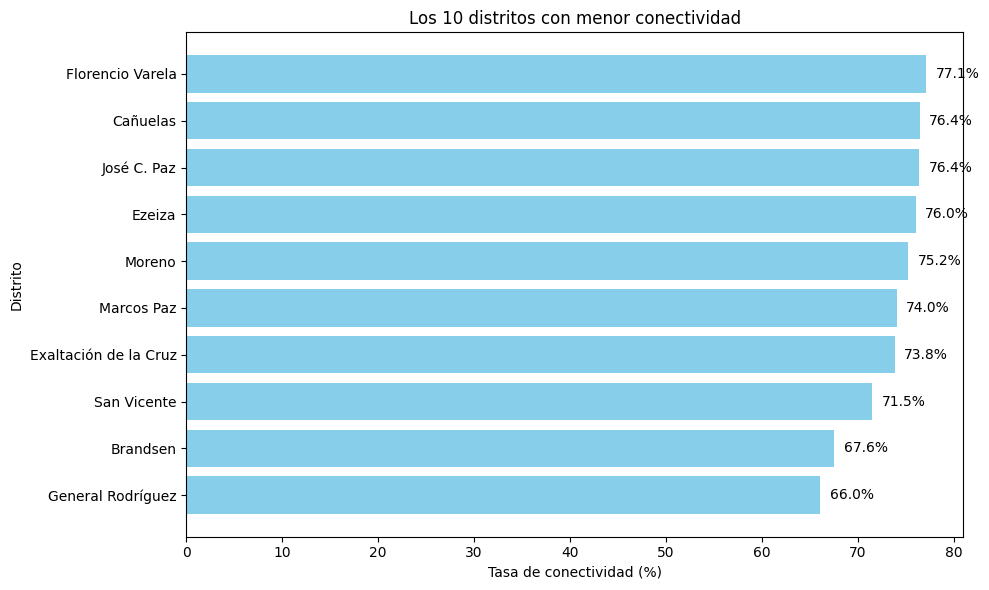

In [ ]:
# %matplotlib inline  # Ya se incluye por defecto en Jupyter

from langchain_experimental.tot.thought_generation import SampleCoTStrategy
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Cargar el DataFrame
df = pd.read_csv("amba_internet.csv")

# 2. Instanciar el modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.1,
    google_api_key="tu?api?key ",  # Reemplazar por tu clave real
    verbose=True
)

# 3. Instanciar SampleCoTStrategy
cot = SampleCoTStrategy(llm=llm, c=5, verbose=True)

# 4. Definir prompt conversacional
prompt = (
    "Usá el DataFrame `df` ya cargado.\n"
    "Contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.\n"
    "Calculá una nueva columna llamada 'tasa_conectividad' como 'tiene_internet / total_hogares * 100'.\n"
    "Seleccioná los 10 distritos con menor conectividad.\n"
    "Generá un gráfico de barras horizontal con matplotlib, donde el eje X muestre la tasa de conectividad y el eje Y el nombre del distrito.\n"
    "Asegurate de que los distritos estén ordenados de menor a mayor conectividad en el eje Y (de abajo hacia arriba).\n"
    "Etiquetá cada barra con el porcentaje de conectividad (formato '82.3%').\n"
    "Usá título en español y no incluyas subtítulos ni texto adicional.\n"
    "Devolvé exclusivamente código Python entre triple backticks (```python ... ```), sin explicaciones."
)


# 5. Generar pensamiento con el modelo
thought = cot.next_thought(problem_description=prompt)
print("\n--- Pensamiento generado ---\n")
print(thought)

# 6. Extraer y ejecutar código con el df cargado
match = re.search(r"```python(.*?)```", thought, re.DOTALL)
if match:
    python_code = match.group(1).strip()
    print("\n--- Código a ejecutar ---\n")
    print(python_code)

    # Ejecutar dentro de un entorno donde df esté definido
    exec_globals = {"df": df.copy(), "pd": pd, "plt": plt}
    exec(python_code, exec_globals)
else:
    print("❌ No se encontró código válido.")

c:\Users\Pedro\Desktop\proyectos_25\agentes\.venv\Lib\site-packages\langchain\chains\llm.py:341: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(




> Entering new SampleCoTStrategy chain...
Prompt after formatting:
You are an intelligent agent that is generating one thought at a time in
a tree of thoughts setting.

PROBLEM 

Usá el DataFrame `df` ya cargado.
Contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.
Sumá los valores totales de 'tiene_internet' y 'total_hogares'.
Calculá cuántos hogares no tienen internet como la diferencia entre ambos.
Generá un gráfico de torta (pie chart) con matplotlib para mostrar la proporción de hogares conectados y no conectados.
Usá colores distintos y etiquetas claras en español ('Conectados', 'No conectados') con sus porcentajes.
Incluí un título en español y devolvé exclusivamente el bloque de código Python entre triple backticks (```python ... ```), sin explicaciones.



Let's think step by step.

> Finished chain.

--- Pensamiento generado ---

Okay, here's the plan:

1.  **Calculate Totals:** Sum the 'tiene\_internet' and 'total\_hogares' columns.
2.  **Calc

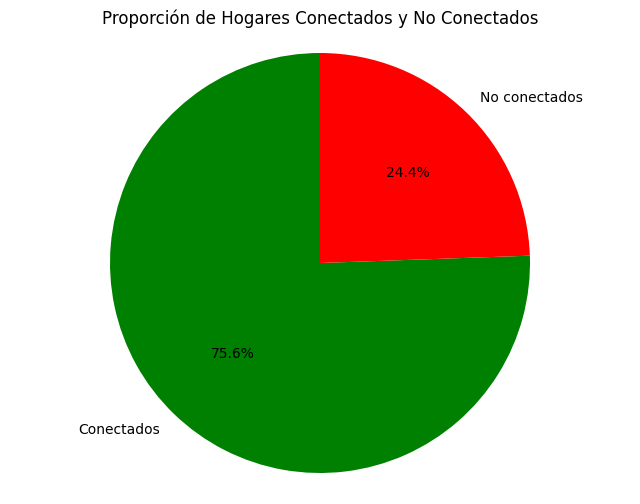

In [ ]:
# %matplotlib inline  # Ya se incluye por defecto en Jupyter

from langchain_experimental.tot.thought_generation import SampleCoTStrategy
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Cargar el DataFrame
df = pd.read_csv("amba_internet.csv")

# 2. Instanciar el modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.1,
    google_api_key="tu?api?key",  # Reemplazar por tu clave real
    verbose=True
)

# 3. Instanciar SampleCoTStrategy
cot = SampleCoTStrategy(llm=llm, c=9, verbose=True)

# 4. Definir prompt conversacional
prompt = (
    "Usá el DataFrame `df` ya cargado.\n"
    "Contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.\n"
    "Sumá los valores totales de 'tiene_internet' y 'total_hogares'.\n"
    "Calculá cuántos hogares no tienen internet como la diferencia entre ambos.\n"
    "Generá un gráfico de torta (pie chart) con matplotlib para mostrar la proporción de hogares conectados y no conectados.\n"
    "Usá colores distintos y etiquetas claras en español ('Conectados', 'No conectados') con sus porcentajes.\n"
    "Incluí un título en español y devolvé exclusivamente el bloque de código Python entre triple backticks (```python ... ```), sin explicaciones."
)

# 5. Generar pensamiento con el modelo
thought = cot.next_thought(problem_description=prompt)
print("\n--- Pensamiento generado ---\n")
print(thought)

# 6. Extraer y ejecutar código con el df cargado
match = re.search(r"```python(.*?)```", thought, re.DOTALL)
if match:
    python_code = match.group(1).strip()
    print("\n--- Código a ejecutar ---\n")
    print(python_code)

    # Ejecutar dentro de un entorno donde df esté definido
    exec_globals = {"df": df.copy(), "pd": pd, "plt": plt}
    exec(python_code, exec_globals)
else:
    print("❌ No se encontró código válido.")


c:\Users\Pedro\Desktop\proyectos_25\agentes\.venv\Lib\site-packages\langchain\chains\llm.py:341: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(




> Entering new SampleCoTStrategy chain...
Prompt after formatting:
You are an intelligent agent that is generating one thought at a time in
a tree of thoughts setting.

PROBLEM 

Trabajá exclusivamente con el DataFrame `df` ya cargado desde el archivo 'amba_internet.csv'.
No generes ningún DataFrame ficticio ni datos inventados. No incluyas datos de ejemplo.
El DataFrame `df` contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.
Calculá una nueva columna llamada 'tasa_conectividad' como 'tiene_internet / total_hogares * 100'.
Seleccioná los 3 distritos con mayor tasa y los 3 con menor tasa de conectividad.
Combiná ambos en un único DataFrame.
Generá un gráfico de barras horizontal con matplotlib, usando un color distinto para cada grupo (por ejemplo, azul para los mayores y rojo para los menores).
Agregá una leyenda que indique qué color representa a cada grupo.
Etiquetá cada barra con el porcentaje (formato '82.3%').
Usá título en español y devolvé exclu

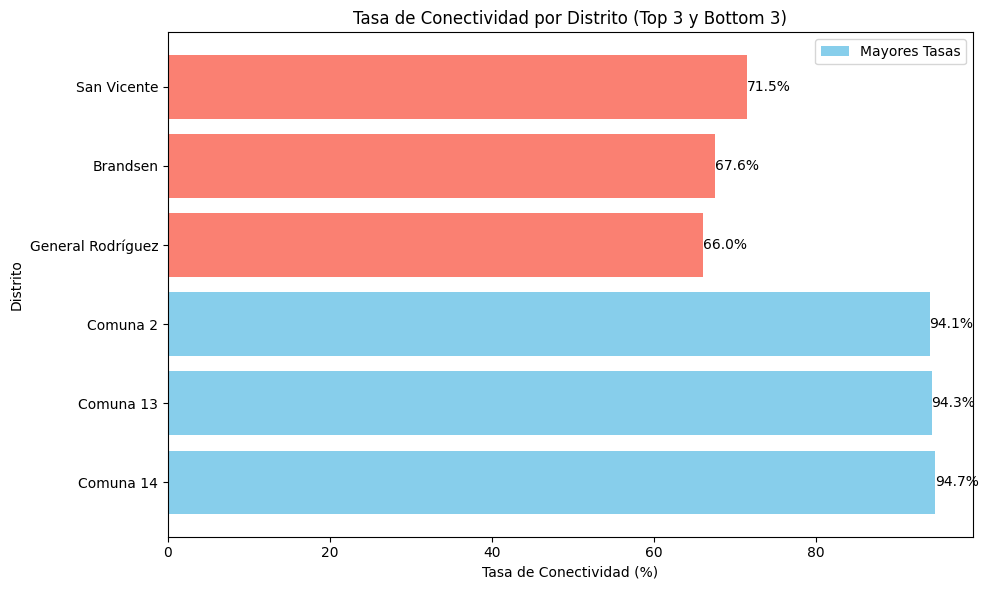

In [ ]:
# %matplotlib inline  # Ya se incluye por defecto en Jupyter

from langchain_experimental.tot.thought_generation import SampleCoTStrategy
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Cargar el DataFrame
df = pd.read_csv("amba_internet.csv")

# 2. Instanciar el modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.1,
    google_api_key="tu?api?key",  # Reemplazar por tu clave real
    verbose=True
)

# 3. Instanciar SampleCoTStrategy
cot = SampleCoTStrategy(llm=llm, c=5, verbose=True)

# 4. Definir prompt conversacional
prompt = (
    "Trabajá exclusivamente con el DataFrame `df` ya cargado desde el archivo 'amba_internet.csv'.\n"
    "No generes ningún DataFrame ficticio ni datos inventados. No incluyas datos de ejemplo.\n"
    "El DataFrame `df` contiene las columnas: 'distrito', 'provincia', 'total_hogares', 'tiene_internet'.\n"
    "Calculá una nueva columna llamada 'tasa_conectividad' como 'tiene_internet / total_hogares * 100'.\n"
    "Seleccioná los 3 distritos con mayor tasa y los 3 con menor tasa de conectividad.\n"
    "Combiná ambos en un único DataFrame.\n"
    "Generá un gráfico de barras horizontal con matplotlib, usando un color distinto para cada grupo (por ejemplo, azul para los mayores y rojo para los menores).\n"
    "Agregá una leyenda que indique qué color representa a cada grupo.\n"
    "Etiquetá cada barra con el porcentaje (formato '82.3%').\n"
    "Usá título en español y devolvé exclusivamente código Python entre triple backticks (```python ... ```), sin explicaciones."
)


# 5. Generar pensamiento con el modelo
thought = cot.next_thought(problem_description=prompt)
print("\n--- Pensamiento generado ---\n")
print(thought)

# 6. Extraer y ejecutar código con el df cargado
match = re.search(r"```python(.*?)```", thought, re.DOTALL)
if match:
    python_code = match.group(1).strip()
    print("\n--- Código a ejecutar ---\n")
    print(python_code)

    # Ejecutar dentro de un entorno donde df esté definido
    exec_globals = {"df": df.copy(), "pd": pd, "plt": plt}
    exec(python_code, exec_globals)
else:
    print("❌ No se encontró código válido.")
